<div align="center">

---
# ML1 | AdaBoost Classifier 
Analysis & Optimization
-
---
</div>

<div align = "center">

--- 
## Project Overview
---
</div>

In recent years, the rise of **Artificial Intelligence** and the widespread use of **Machine Learning** have revolutionized the way we **tackle complex real-world challenges**. However, due to the diverse nature of data involved, **choosing the right algorithm is crucial** to achieve efficient and effective solutions. Therefore, understanding the **strengths and weaknesses** behind different Machine Learning algorithms, and knowing how to **adapt them** to meet specific challenges, can become a fulcral skill to develop.

Furthermore, since the choice of algorithm greatly depends on the **specific task and data involved**, it's clear that there is no __*Master Algorithm*__ (No algorithm can solve every problem). For example, while Linear Discriminants effectively delineate boundaries in data that is linearly separable, they struggle to capture relationships in more complex, higher-dimensional spaces. Therefore, this Project focuses on the **following topic**:

<div align="center">
    
> With **No Master Algorithm**, is it possible to **improve** a existing Machine Learning Algorithm in **characteristics it struggles the most**?
</div>

Furthermore, after **choosing a Machine Learning algorithm** and gaining a thorough understanding of its theoretical and empirical aspects, **we aim to refine it**, specifically **targeting its weaknesses** in solving classification problems.

<div align = "center">

--- 
## Classifier Selection
---
</div>

Nowadays, since **singular Machine Learning Algorithms** can fall short to predict the whole data given, we decided to study an **Ensemble Algorithm**. Since these Algorithms can combine outputs of multiple models it makes them more prone to **better address more complex problems** and **provide better solutions**.

Consequently, after careful consideration, we decided to focus on enhancing the **AdaBoost Algorithm M1**, which is employed in **binary classification problems**.

<center><img src="./Assets/Boosting.gif" width="500" title="Boosting"></center>

<div align = "center">

--- 
## AdaBoost Overview
---
</div>

**AdaBoost** (Adaptive Boosting) is a type of ensemble learning technique used in machine learning to solve both **classification** and **regression** problems. It consists on training a series of weak classifiers on the dataset. Therefore, with each iteration, the algorithm **increases the focus** on data points that were **previously predicted incorrectly**.

As a result, the AdaBoost algorithm builds a model by considering all the individual **weak classifiers** which are **weighted based on their performance**. Consequently, classifiers with **higher predictive accuracy contribute more to the final decision** which **reduces the influence of less accurate ones** in the final prediction. 

Finally, here's the **pseudocode** behind the AdaBoost M1 Algorithm used in this Notebook:

<div align = "center">

--- 
### AdaBoost.M1 [Pseudocode]
---
</div>

1. Initialize the observation weights $w_i = \frac{1}{N}$, for $i = 1, 2, \dots, N$.

2. For $ m = 1 $ to $ M $:
   \
   a) Fit a classifier $ G_m(x) $ to the training data using weights $ w_i $
   \
   b) Compute
      $$
      \text{err}_m = \frac{ \sum_{i=1}^N w_i I(y_i \neq G_m(x_i)) }{ \sum_{i=1}^N w_i }
      $$
   c) Compute $ \alpha_m = \log\left(\frac{1 - \text{err}_m}{\text{err}_m}\right) $
   \
   \
   d) Set $ w_i \leftarrow w_i \cdot \exp\left(\alpha_m \cdot I(y_i \neq G_m(x_i))\right) $, for $ i = 1, 2, \dots, N $.

4. Output $ G(x) = \text{sign}\left( \sum_{m=1}^M \alpha_m G_m(x) \right) $.


> **Source**: *The Elements of Statistical Learning, ch. 10*

<div align = "center">

--- 
### AdaBoost.M1 [Step Guide]
---
</div>

As previously discussed, AdaBoost techniques combine many weak machine-learning models to create a **powerful classification model** for the output which envolves the following steps:

1. **Initialize the Weights**
    - For a dataset with $N$ training data points instances, initialize $N W_{i}$ weights for each data point with $W_{i} = \frac{1}{N}$

<p></p>

2. **Train Weak Classifiers**
    - Train a weak classifier $M_k$ where $k$ is the current iteration
    - The weak classifier we are training should have an accuracy greater than 0.5 which means it should be performing better than a naive guess

<p></p>

3. Calculate the **Error Rate** and **importance of each weak model $M_k$**
    - Calculate rate $error\_rate$ for every weak classifier $M_k$ on the training dataset
    - Calculate the importance of each model $α\_k$ using formula $\alpha_k = \frac{1}{2} \ln{\frac{1 – error_k}{error_k}}$

<p></p>

4. **Update** data point **weight** for each data point $W_i$:
    - After applying the weak classifier model to the training data we will update the weight assigned to the points using the accuracy of the model. The formula for updating the weights will be $w_i = w_i \exp{(-\alpha_k y_i M_k(x_i))}$. Here $y_i$ is the true output and $X_i$ is the corresponding input vector

<p></p>

5. **Normalize the Instance weight**
    - We will normalize the instance weight so that they can be summed up to 1 using the formula $W_i = W_i / sum(W)$

<p></p>

6. **Repeat steps 2-5 for $K \space iterations$**
    - We will train $K \space classifiers$ and will calculate model importance and update the instance weights using the above formula
    - The final model $M(X)$ will be an ensemble model which is obtained by combining these weak models weighted by their model weights

Theoretically the **AdaBoost Algorithm** can use any Machine Learning algorithm as **Weak Learners**. However, depending on the **problem and data** at hand, the final model might require a **more delicate** approach on it's **evaluation**. Therefore the **best** algorithms to use as **weak learners** are typically those that are **fast**, **simple** and slightly **better than random guess** which is why we started developing AdaBoost with **Stumps** (Decision Trees of Depth 1). 

<div align = "center">

--- 
### AdaBoost.M1 [Disadvantages]
---
</div>

Despite the Algorithms powerfull techinques, it yet remains **limited by a few factors**.

#### $\rightarrow$ Noisy Data and Outliers

For instance, if the AdaBoost algorithm is used upon **noisy data**, it can **focus too much on correcting previous misclassifications** despite their actual trends, which can lead to **overfitting**. Moreover, **outliers** can also impact the algorithm's performance significantly. Since AdaBoost tries to perfectly fit each example, it can **overlook on rare instances** in the data rather than finding the **actual patterns** within it.

#### $\rightarrow$ Choice of Weak Learner

Furthermore, AdaBoost can be quite **sensitive to the used Weak Learners**. As previously mentioned, the best weak models are often described as **simple**, **fast** and with low variance. Therefore, they **do not memorize the training data** but rather **learn to generalize** different aspects within the data.

#### $\rightarrow$ Computational Cost

Since AdaBoost consists of a Boosting Algorithm, it's performance mainly depends on the **amount of boosting rounds** performed during training. This main hyperparameter can easily **affect the model's effectiveness** which can lead to **overfitting** as well as to **high computational costs**.

<div align = "center">

--- 
## Importing Dependencies
---
</div>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Remove Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Project's Dependencies
import numpy as np
import pandas as pd
import openml
from sklearn.model_selection import (train_test_split)
from scipy.stats import (friedmanchisquare)
from sklearn.ensemble import (AdaBoostClassifier)

from AdaBoostStudy.AdaBoost import (AdaBoost)
from AdaBoostStudy.DataPreprocessing import (Fetch_Dataset, Fetch_X_y)
from AdaBoostStudy.ModifiedAdaBoost import (AdaBoostTunedDT, AdaBoostPerceptron)
from AdaBoostStudy.ModelEvaluation import (Save_json_file, Load_json_file, Manage_Results, Perform_KFold_CV, Perform_Mean_KFold_CV, Evaluate_Models)
from AdaBoostStudy.DataVisualization import (Plot_Scatterplots, Display_Confusion_Matrix, Plot_ROC_Curve, Plot_Model_Stats, Model_Accuracies_Per_Dataset, Plot_Critial_Difference_Diagram)

<div align = "center">

--- 
## Data Preprocessing [Datasets Selection]
---
</div>

Since the developed AdaBoost Algorithm focuses on **Binary Classification Problems**, we decided to filter all the datasets inside the `OpenML-CC18 Curated Classification` study. Consequently, by selecting those with **2 possible target values** we will can ensure a **proper training of our Models**.

In [3]:
# List all tasks in the 'OpenML-CC18' benchmark
benchmark = openml.study.get_suite('OpenML-CC18')
df_tasks = openml.tasks.list_tasks(output_format="dataframe", task_id=benchmark.tasks)
df_tasks.head()

,tid,ttid,did,name,task_type,status,estimation_procedure,source_data,target_feature,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
3,3,TaskType.SUPERVISED_CLASSIFICATION,3,kr-vs-kp,Supervised Classification,active,10-fold Crossvalidation,3,class,1669,3.0,1527,2,37,3196,0,0,0,37
6,6,TaskType.SUPERVISED_CLASSIFICATION,6,letter,Supervised Classification,active,10-fold Crossvalidation,6,class,813,26.0,734,26,17,20000,0,0,16,1
11,11,TaskType.SUPERVISED_CLASSIFICATION,11,balance-scale,Supervised Classification,active,10-fold Crossvalidation,11,class,288,3.0,49,3,5,625,0,0,4,1
12,12,TaskType.SUPERVISED_CLASSIFICATION,12,mfeat-factors,Supervised Classification,active,10-fold Crossvalidation,12,class,200,10.0,200,10,217,2000,0,0,216,1
14,14,TaskType.SUPERVISED_CLASSIFICATION,14,mfeat-fourier,Supervised Classification,active,10-fold Crossvalidation,14,class,200,10.0,200,10,77,2000,0,0,76,1


In [4]:
# Creating a Dictionary to store each dataset's information
my_tasks = {}

for task_id in df_tasks.loc[df_tasks['NumberOfClasses'] == 2]['tid'].to_numpy():
    name, ds = Fetch_Dataset(task_id)
    
    target_values = list(np.unique(ds['target']))
    
    if (len(target_values) > 0 and task_id not in my_tasks.keys()):
        
        features = list(ds.columns[:-1])
        target = ds.columns[-1]
        
        content = {'Name':name,
                   'Features':features,
                   'Target':target,
                   'TargetValues':target_values}
        
        my_tasks.update({task_id: content})

In [5]:
# Display all the datasets selected
for task_id, info_task in my_tasks.items():
    name, ds = Fetch_Dataset(task_id)
    print(f"[Dataset ID {task_id}]: {info_task['Name']}\n")
    print(f"[Features]: {info_task['Features']}", '\n')
    print(f"[Target]: {info_task['Target']}", '\n')
    print(f"[Target Values]: {info_task['TargetValues']}", '\n')
    print('-'*30, '\n')

[Dataset ID 3]: kr-vs-kp

[Features]: ['bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq', 'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr', 'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk', 'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 15]: breast-w

[Features]: ['Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Marginal_Adhesion', 'Single_Epi_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 29]: credit-approval

[Features]: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'] 

[Target]: target 

[Target Values]: [-1, 1] 

------------------------------ 

[Dataset ID 31]: credit-g

[Featur

<div align = "center">

--- 
## Base Model Evaluation
---
</div>

Initially we started by evaluating the Algorithm in order to obtain ground results to be later used as **control values** against new results provided by **modified versions of the algorithm**. Therefore, by performing a **K-Fold Cross Validation** (5 Folds) upon the selected datasets, we were able to determine an **estimate of the Base Model's overall Accuracy**.

In [6]:
try:
    # Model Already Evaluated with the results Stored
    Base_Results = pd.read_csv('./Experimental Results/AdaBoost_Base_Results.csv')
except:
    # Evaluating the Base Model as well as the Sklearn's version
    Base_Results, _ = Evaluate_Models(my_tasks, [AdaBoost(), AdaBoostClassifier()], ['AdaBoost [Base]', 'AdaBoost [Sklearn]'])
    Base_Results.to_csv('./Experimental Results/AdaBoost_Base_Results.csv', index=False)

Base_Results

,Dataset,Positive Class (%),Negative Class (%),Majority Class (%),AdaBoost [Base],AdaBoost [Sklearn]
0,kr-vs-kp,0.477785,0.522215,0.522215,0.940859,0.964325
1,breast-w,0.349927,0.650073,0.650073,0.963418,0.956086
2,credit-approval,0.546708,0.453292,0.546708,0.872860,0.849877
3,credit-g,0.300000,0.700000,0.700000,0.758000,0.753000
4,diabetes,0.348958,0.651042,0.651042,0.769612,0.751354
5,spambase,0.394045,0.605955,0.605955,0.933927,0.940009
6,tic-tac-toe,0.653445,0.346555,0.653445,0.732755,0.773467
7,electricity,0.575455,0.424545,0.575455,0.770635,0.811728
8,pc4,0.122085,0.877915,0.877915,0.893019,0.901923
9,pc3,0.102367,0.897633,0.897633,0.895072,0.885476


As we can observe from the results obtained, we can infer that our **AdaBoost Algorithm was well implemented** since it's accuracies on the selected datasets **do not differ significantly** from the ones obtained by the **Scikit-Learn's Version**.

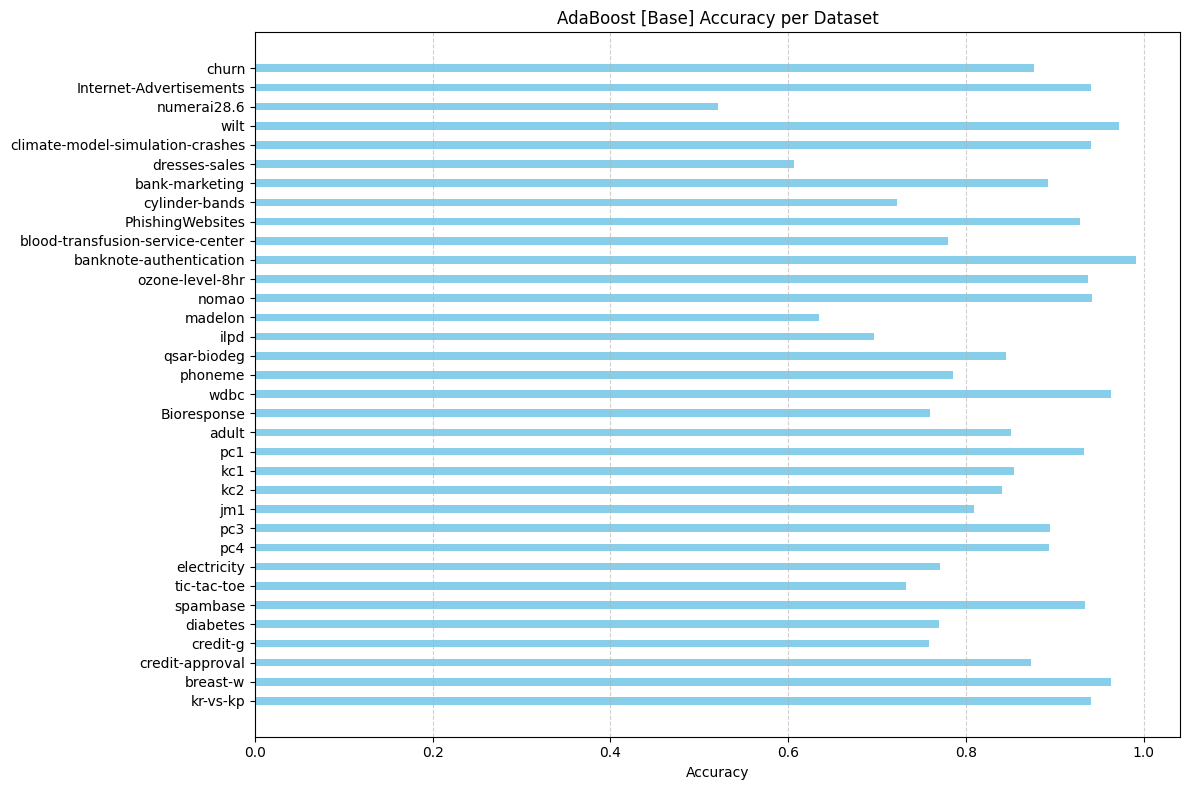

In [7]:
# Plotting the Base Reults of our algoritm's base implementation
Model_Accuracies_Per_Dataset(Base_Results, 'AdaBoost [Base]')

> This Barplot displays the **Average Accuracy** obtained by the Algorithm upon each **selected dataset**.

    Overall, the AdaBoost Algorithm seems to be performing well against most of the datasets.

Furthermore, in order to **dive deeper** on how the Algorithm **performs** we dicided to evaluate it against one of the selected datasets. We considered the `Breast-W Dataset` against the following concepts:

- **Weak Learner's Training Error**
  - Evaluating how the weak learner's **error evolves during training** can provide great insights on how they affect the overall algorithm.
- **Weak Learner's Weights**
  - The weights of each weak learner can help understand the **impact of each classifier on the final decision**.
- **Confusion Matrix**
  - Matrix that conveys the model's **classification results** (TP, TN, FP, FN).
- **ROC Curve**
  - Provides a great understanding of the **model's tradeoffs** between both **true positive and false positive rates**.
  - Alongside the ROC Cuve, the **AUC (Area Under Curve)** also helps quantify the model's classification **performance**.

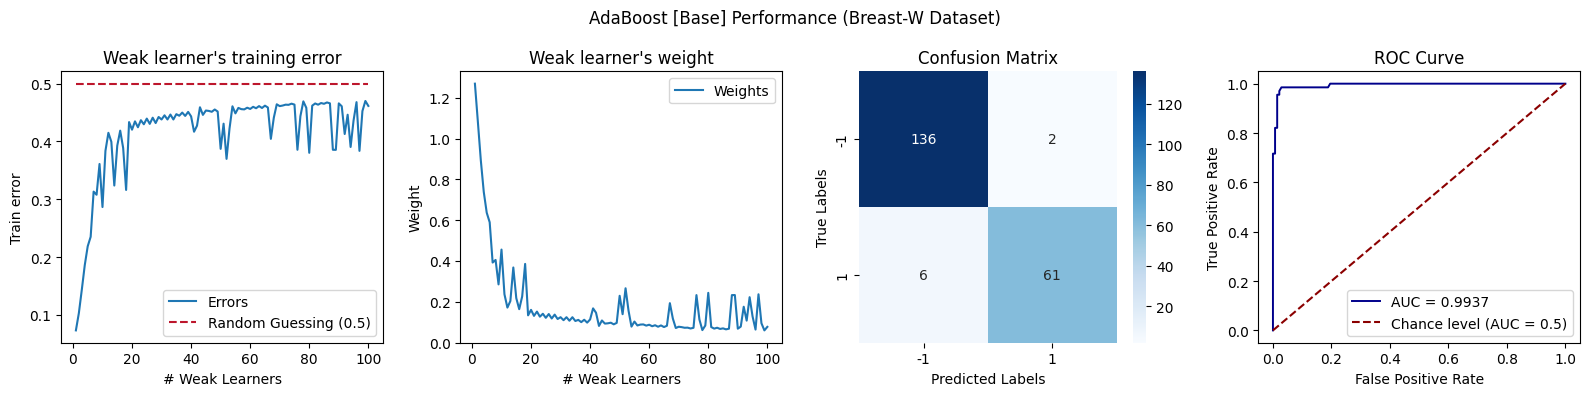

In [8]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoost()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [Base] Performance (Breast-W Dataset)")

As we train additional weak learners with new subsets of data in each **boosting round**, we observe their **influence in the final decision decrease** while their **training error increases**. This trend occurs because the initial weak learners **process more "new" data** and are therefore better positioned to **identify effective classification boundaries**, thus having a **greater impact on the final prediction**. As boosting progresses, the data used to train these weak learners begin to concentrate on previously misclassified examples (a characteristic of the AdaBoost algorithm $\rightarrow$ reinforcing learning from past errors). However, if these data points are actually **outliers**, the algorithm **risks overfitting** by continuously **trying to correct** misclassifications that **do not enhance pattern recognition** within the overall dataset.

The algorithm demonstrates **strong performance on the Breast-W dataset**, which is evident from the **Confusion Matrix** (accurately classifies most of the samples) and the **ROC Curve**. With an **AUC of 0.9856**, we can confidently infer that the model **excels in handling the provided dataset**.

$\rightarrow$ In the next Section we are going to focus on **tempering with the algorithm's weaknesses** in order to improve it. In addition, by performing **statistical inference** upon **new modified models** on the selected datasets, we are capable of comparing the **algorithm's improvement** face the previous control results.

<div align="center">

---
> ## REVISE
## Proposal
---
</div>

Following an analysis of the inherent challenges faced by the AdaBoost Algorithm and potential enhancements, we chose to address its performance issues with **Imbalanced Data**. Due to its iterative nature, AdaBoost tends to **concentrate training efforts on data points that were previouslty misclassified**. This can cause the model to excessively **focus on the minority class**, which may include noisy data and outliers, thereby **increasing the risk of overfitting**.

Consequently, we have embarked on an investigation to **explore the impact of weak learners** on the algorithm's effectiveness in **Binary Classification scenarios involving imbalanced datasets**. This study aims to identify modifications or adaptations in weak learners that might improve how AdaBoost handles class imbalance, **enhancing its overall predictive accuracy and robustness**.

--- 
### Choice of Weak Learners
---

As previously mentioned, **weak learners** should not only be capable of achieving performance levels that are **slightly better than random guessing** but also remain **simple enough** so that they do not require high computational costs. Therefore, we propose using:

$\rightarrow$ **Decision Trees with Increased Depth**
  - In AdaBoost, decision stumps are commonly used since they are less prone to overfit. However, **slightly deeper trees** (Max Depth of 3 as used below) might be more beneficial to **capture more complex patterns** without causing significant overfitting.

$\rightarrow$ **Perceptrons**
  - Perceptrons are **simple linear classifiers** that compute a weighted sum of inputs to make decisions which leads to **faster training times** compared to decision trees.
  - For datasets with **linearly separable data**, perceptrons often **converge quickly to a good solution** making them very effective.
  - Due to their simplicity, Perceptrons can **prevent** the Model from becoming **too complex**. This simplicity can be **advantageous in imbalanced datasets** where complex models might overfit by learning too much from the minority class examples (Noise and Outliers).

<div align="center">

---
## Empirical Study
---
</div>

In [9]:
WEAK_LEARNERS_FILE = './Experimental Results/AdaBoost_Weak_Learner_Modifications_Results'
try:
    Weak_Learner_Modifications_Results_df = pd.read_csv(WEAK_LEARNERS_FILE + '.csv')
    Weak_Learner_Modifications_Results = Load_json_file(WEAK_LEARNERS_FILE + '.json')
except:
    models = [AdaBoost(), AdaBoostTunedDT({'max_depth':3}), AdaBoostPerceptron()]
    (Weak_Learner_Modifications_Results_df,
     Weak_Learner_Modifications_Results) = Evaluate_Models(my_tasks, models, ['AdaBoost [Base]', 'AdaBoost [DT - MaxDepth 3]', 'AdaBoost [Perceptron]'])
    
    Weak_Learner_Modifications_Results_df.to_csv(WEAK_LEARNERS_FILE + '.csv', index=False)
    Save_json_file(Weak_Learner_Modifications_Results, WEAK_LEARNERS_FILE + '.json')

Weak_Learner_Modifications_Results_df

,Dataset,Positive Class (%),Negative Class (%),Majority Class (%),AdaBoost [Base],AdaBoost [DT - MaxDepth 3],AdaBoost [Perceptron]
0,kr-vs-kp,0.477785,0.522215,0.522215,0.940859,0.987169,0.966204
1,breast-w,0.349927,0.650073,0.650073,0.963418,0.969257,0.963386
2,credit-approval,0.546708,0.453292,0.546708,0.872860,0.874422,0.685966
3,credit-g,0.300000,0.700000,0.700000,0.758000,0.769000,0.700000
4,diabetes,0.348958,0.651042,0.651042,0.769612,0.759121,0.664112
5,spambase,0.394045,0.605955,0.605955,0.933927,0.945226,0.855681
6,tic-tac-toe,0.653445,0.346555,0.653445,0.732755,0.986420,0.670152
7,electricity,0.575455,0.424545,0.575455,0.770635,0.814972,0.720604
8,pc4,0.122085,0.877915,0.877915,0.893019,0.901928,0.862825
9,pc3,0.102367,0.897633,0.897633,0.895072,0.881005,0.873974


As we can observe from the results, the modified version of AdaBoost that use **Decision Trees with increased depth** appears to perform **slightly better** than the original version despite not being able to significantly outperform it. However the same does not occur when using Perceptrons as weak learners. In fact, the use of Perceptrons makes the Algorithm **perform even worse** than the standard version of AdaBoost.

> $\rightarrow$ Let's analyse how they behave against the previous dataset - `Breast-W Dataset`

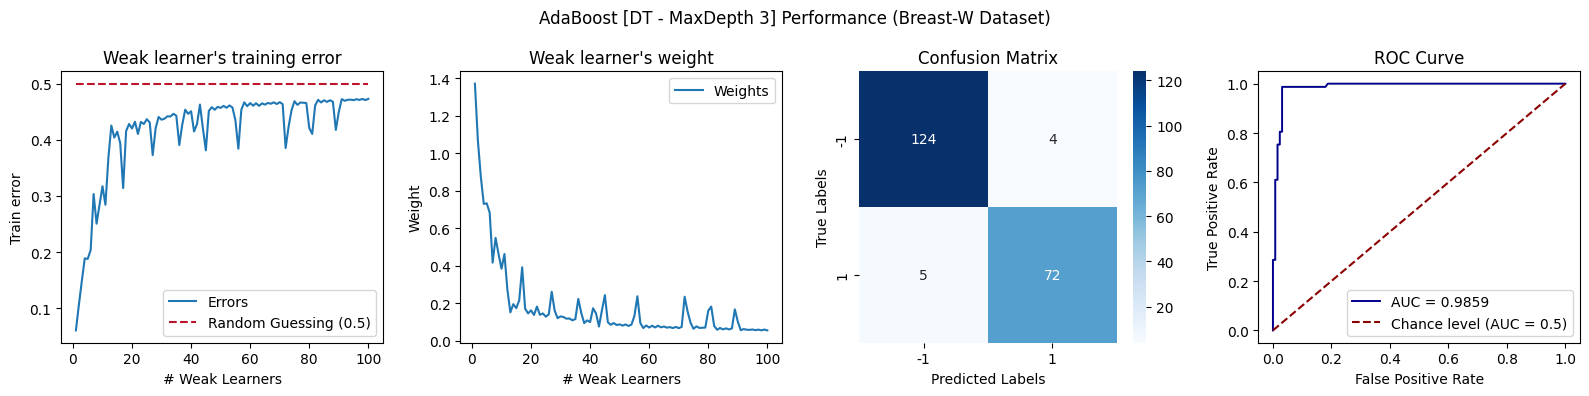

In [10]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoostTunedDT()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [DT - MaxDepth 3] Performance (Breast-W Dataset)")

Similarly to the results obtained with the base algorithm, the AdaBoost with increased depth on the weak learners seems to **correctly classify most cases** which corroborates with the good performance shown in the **ROC Curve** diagram. In addition, the algorithm evolves similarly to the original version throughout each **boosting round** which makes it converge to a **good solution**.

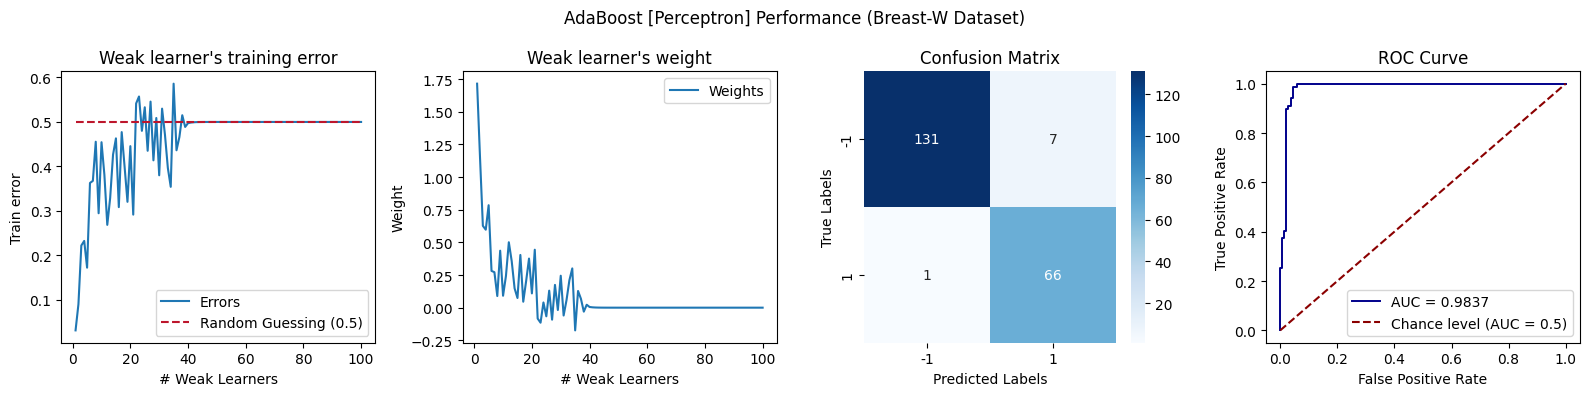

In [11]:
# Model Performance Evaluation on the Breast-W Dataset (Task ID 15)
name, X, y = Fetch_X_y(task_id=15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ab = AdaBoostPerceptron()
ab.fit(X_train, y_train)
Plot_Model_Stats(ab, X_test, y_test, "AdaBoost [Perceptron] Performance (Breast-W Dataset)")

The AdaBoost model using Perceptrons as weak learners shows **promising classification results** on the Breast-W dataset, but aspects of the **performance** closely resemble **random guessing**. This behaviour raises concerns about whether **these learners can outperform random guessing**, a **key expectation** in the AdaBoost’s iterative strategy effectively.

A **analysis of the weak learner's weights and training errors** over 100 boosting rounds reveal that the **error rates** of individual weak learners stabilize near the **random guessing threshold** which suggests **minimal learning progress**. This pattern shows **potential limitations of Perceptrons** since AdaBoost's main concept (**refine decision boundaries through targeted training on misclassified cases**) **may not be fully utilized**.

Moreover, the influence of these weak learners on the ensemble's decisions quickly decreases, indicating that **early learners might not provide a solid foundation** for subsequent ones.

Our following analysis will aim to determine **how many weak learners perform at or below random guessing level** and assess how it affects the model’s overall **accuracy**.

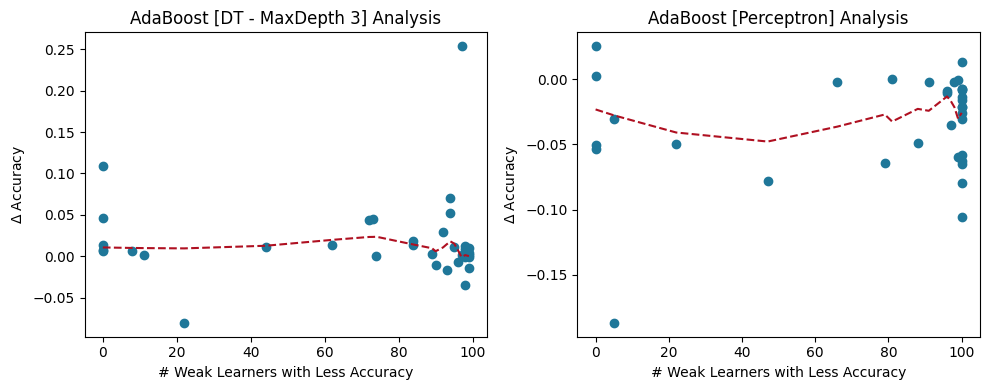

In [12]:
# Analysing the Weak Learners Performance for each new version of AdaBoost
results = Manage_Results(Weak_Learner_Modifications_Results)
Titles = [f"{Weak_Learner_Modifications_Results_df.columns[idx+5]} Analysis" for idx in range(len(Weak_Learner_Modifications_Results_df.columns)-5)]
Plot_Scatterplots(results, Titles, f"$\Delta$ Accuracy", '# Weak Learners with Less Accuracy')

The results obtained reveal **distinct bahaviours** from both modified algorithms.

On one hand, the $\Delta$ Accuracy for the AdaBoost model employing **decision trees with Max Depth 3** **fluctuates around zero** with a few outliers that demonstrate **accuracy improvements**. This trend suggests that while this configuration performs similarly to the Base AdaBoost Model, it **occasionally achieves superior results** - when the **decision boundaries are more complex but still manageable** by the weak learner. In addition, this relatively **stable performance** indicates that increasing the depth of the decision tree **does not offer a clear advantage** over simpler stumps.

On the other hand, the AdaBoost model utilizing **Perceptrons** shows a distinct trend of **negative $\Delta$ Accuracy**, mostly remaining **below the zero mark**. This shows that Perceptron-based weak learners consistently **underperform** compared to the **stumps** used in the Standard Version of the Algorithm.

In this version of AdaBoost, each Perceptron in the sequence is meant to **correct the misclassifications** of its predecessors. However, if the data requires **non-linear separation**, the linear boundaries created by each Perceptron **cannot effectively tackle the misclassified examples** unless those errors happen to align with a **linearly separable pattern** which is usually not the case with **complex datasets**.

In Suma, this consistent negative $\Delta$ Accuracy highlights the inability of Perceptrons to capture non-linear relationships in the data.

<div align="center">

---
## Statistical Inference
---
</div>

### FriedMan Test

To assess whether there are **significant differences** in the performance of the models, we chose to conduct a `Friedman Test` since it is especially effective for **comparing the performance of different models** across multiple datasets. Therefore, it focuses in determining whether **any model outperforms the others** or if the **differences** in their performances are **statistically significant**.

#### Hypothesis Formulation

`Null Hypothesis` ($H_0$) : All the Models have the **same performance** and therefore **there are no significant differences** between them:
$$\mu_1 = \mu_2 = \mu_3$$

`Alternative Hypothesis` ($H_1$) : At least **one of the models performs differently** compared to at least one of the other models, i.e.:
$$ \forall \space j \space \exists \space i \space, \space j \space, \space i \space \in \{1, 2, 3\} \space \land \space (j \space \neq i) \space : \space \mu_j \neq \mu_i$$

#### Decision Making

- If $(P-Value > \alpha)$, $H_0$ is **not rejected** and therefore there is **not enough evidence** to conclude that there is **any difference between the model's performances**.
- If $(P-Value \le \alpha)$, $H_0$ is **rejected** and therefore **not all the models perform equally well**.

> Being $\alpha$ the **significance level** (typicaly 0.05)

In [13]:
# Getting the Model's Accuracies
base_accuracies = Weak_Learner_Modifications_Results_df['AdaBoost [Base]'].to_numpy()
dt_accuracies = Weak_Learner_Modifications_Results_df['AdaBoost [DT - MaxDepth 3]'].to_numpy()
perceptron_accuracies = Weak_Learner_Modifications_Results_df['AdaBoost [Perceptron]'].to_numpy()

# Performing the FriedMan Test
ET, PValue = friedmanchisquare(base_accuracies, dt_accuracies, perceptron_accuracies)
print('Statistics = %.3f, P-Value = %.3e' % (ET, PValue))

# Interpretation based on p-value
if PValue <= 0.05:
    print(f"Reject the Null Hypothesis (H0)")
else:
    print(f"Fail to reject the Null hypothesis (H0)")

Statistics = 41.353, P-Value = 1.048e-09
Reject the Null Hypothesis (H0)


> $\rightarrow$ For a **significance level of 0.05** ($\alpha = 0.05$), the $P-Value \approx 1.048 \cdot 10^{-9}$ and therefore we **reject the Null Hypothesis** ($H_0$) and consequently conclude that **there are significant differences between the studied models**.

#### Post-Hoc Tests

Since we **rejected the Null Hypothesis**, we concluded that there were **significant differences** between the model's performances. However, since the **FriedMan Test** alone does not explicitly convey what specific models are significantly different from each other, we need to conduct a `Post-Hoc Test` to determine which **model pairs** are significantly different.

After careful consideration, we chose to perform a **Nemenyi Test** (**Compares all pairs of groups** to determine which ones differ significantly) and plot the results within a **Critical Difference Diagram**.

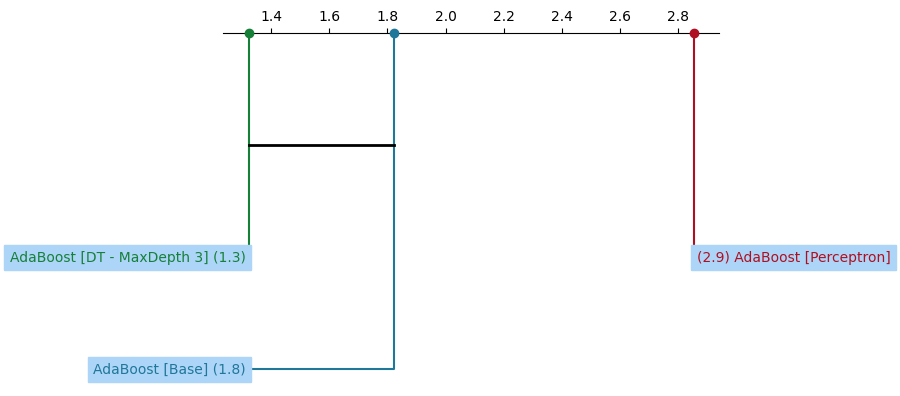

In [14]:
# Plotting tbe Critical Difference Diagram (Recurring to the Nemenyi Test)
weak_learner_modifications_matrix = Weak_Learner_Modifications_Results_df.drop(list(Weak_Learner_Modifications_Results_df.columns[0:4]), axis=1)
colors = {'AdaBoost [Base]':'#1F7799', 'AdaBoost [DT - MaxDepth 3]':'#168039', 'AdaBoost [Perceptron]':'#AF1021'}
Plot_Critial_Difference_Diagram(weak_learner_modifications_matrix, colors)

> The AdaBoost with a **Decision Tree of Max Depth 3** and the **Standard Version of AdaBoost** model **perform similarly** and significantly better than the one that uses **Perceptrons as weak learners**. These differences suggest that **decision trees are more suited for boosting** in the Binary Classification Scenario.

<div align="center">

---
## Conclusions
---
</div>

Despite our dedicated efforts to **enhance the AdaBoost algorithm for imbalanced data**, we were unable to overcome the challenges presented and thus **did not achieve an improvement over the original algorithm**.

Nonetheless, our investigation provided valuable insights into the **dynamics of AdaBoost** and the significant impact that the **choice of weak learners** has on its performance across **different types of datasets**. Most notably, we conclusively determined that **Decision Trees are more effective than Perceptrons when used as weak learners** within the AdaBoost framework. This understanding reveals the **importance of selecting appropriate weak learners** based on the **specific characteristics and demands of the dataset at hand**.

<div align="center">

---
## Future Work
---
</div>

In our **future work on the AdaBoost Algorithm**, we plan to tackle its tendency toward **overfitting** by refining crucial elements of its architecture. We intend to **enhance the error computation methods**, optimize the **update mechanisms for the weights of each weak learner**, and adjust the **weighting strategy for training data in subsequent boosting rounds**. These modifications aim to **regulate the algorithm's excessive focus on previously misclassified examples**, reducing the undue **influence of noisy data and outliers**. By making these adjustments, we anticipate **improving the model’s generalization capabilities** and achieving more stable and accurate predictive performances.

<div align="center">

***
## Bibliographic References
***
</div>

1. Cano. Alvaro (Towards Data Science, 2021). __*AdaBoost from Scratch*__. Available [here](https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50)
2. Geeks For Geeks (2023). __*Boosting in Machine Learning | Boosting and AdaBoost*__. Available [here](https://www.geeksforgeeks.org/boosting-in-machine-learning-boosting-and-adaboost/)
3. Geeks For Geeks (2024). __*Implementing the AdaBoost Algorithm from Scratch*__. Available [here](https://www.geeksforgeeks.org/implementing-the-adaboost-algorithm-from-scratch/)

___
## Final Considerations

$\quad$ If there is any difficulty on downloading or executing this project, please contact us via:

- **Email**:
    - [Gonçalo Esteves](https://github.com/EstevesX10) &#8594; `up202203947@up.pt`
    - [Nuno Gomes](https://github.com/NightF0x26) &#8594; `up202206195@up.pt`